In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import csv
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from PIL import Image, UnidentifiedImageError
from pillow_heif import register_heif_opener
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch
import joblib
from torchvision import transforms


# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

In [16]:
#Create an ml neural network that reads cursive letters

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)

In [17]:
register_heif_opener()

path = "Cursive"
rows = []

#Recieved and data from text folder and converted to csv file
for dirpath, _, filenames in os.walk(path):
     for filename in filenames:
        filepath = os.path.abspath(os.path.join(dirpath, filename))
        label = os.path.splitext(filename)[0].lower()  
        try:
            with Image.open(filepath) as img:
                width, height = img.size
            size_kb = os.path.getsize(filepath) / 1024
            rows.append([label, filepath, width, height, size_kb])
        except UnidentifiedImageError:
            print(f"Skipping unreadable file: {filepath}")


#Recieved and read the data from the csv file using pandas
data = pd.DataFrame(rows, columns=['Label', 'FilePath', 'Width', 'Height', 'FileSizeKB'])
data.to_csv("Cursive.csv", index=False)
data = data[data['Label'].str.len() == 1].reset_index(drop=True)

data.head()

,Label,FilePath,Width,Height,FileSizeKB
0,n,/home/jupyter-260721/Machine-Learning-AI-Class...,1501,1127,896.290039
1,a,/home/jupyter-260721/Machine-Learning-AI-Class...,1270,1047,648.894531
2,b,/home/jupyter-260721/Machine-Learning-AI-Class...,1564,1144,975.461914
3,c,/home/jupyter-260721/Machine-Learning-AI-Class...,2099,1482,1760.179688
4,k,/home/jupyter-260721/Machine-Learning-AI-Class...,1449,1147,923.542969


# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

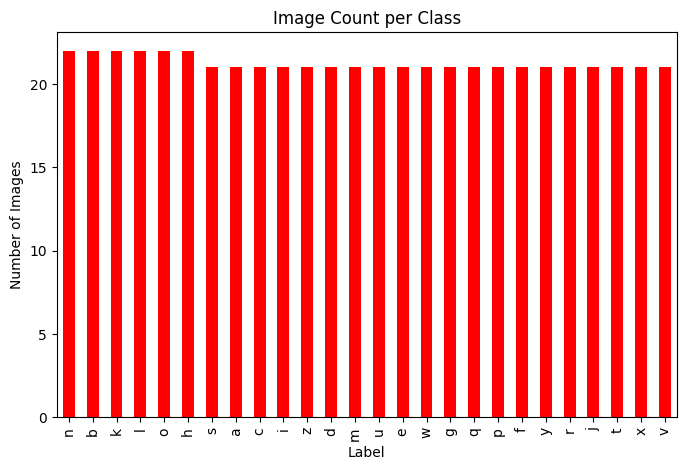

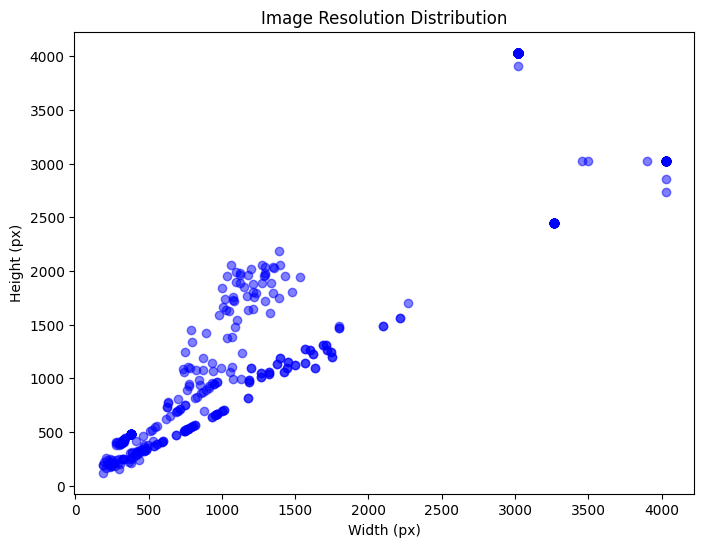

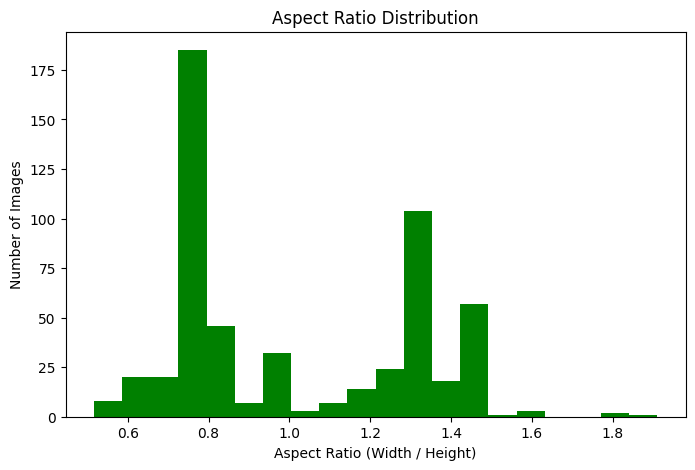

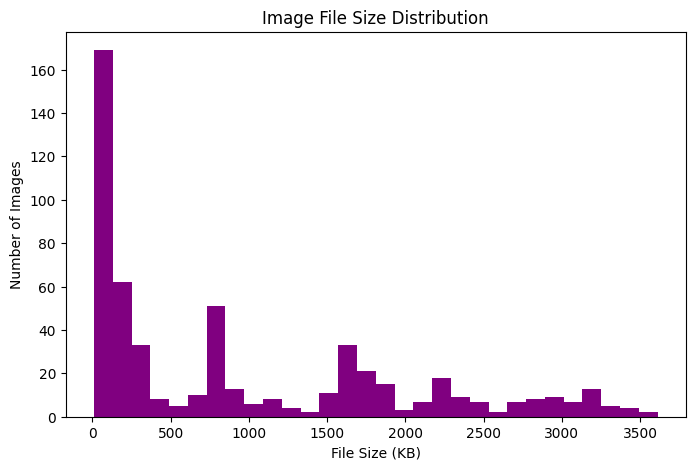

In [18]:

#Checks image count per label
plt.figure(figsize=(8,5))
data['Label'].value_counts().plot(kind='bar', color='red')
plt.ylabel('Number of Images')
plt.title('Image Count per Class')
plt.show()

#Checks height and width of images 
plt.figure(figsize=(8,6))
plt.scatter(data['Width'], data['Height'], alpha=0.5, color='blue')
plt.xlabel('Width (px)')
plt.ylabel('Height (px)')
plt.title('Image Resolution Distribution')
plt.show()

#Checks aspect ratio of images
data['AspectRatio'] = data['Width'] / data['Height']
plt.figure(figsize=(8,5))
plt.hist(data['AspectRatio'], bins=20, color='green')
plt.xlabel('Aspect Ratio (Width / Height)')
plt.ylabel('Number of Images')
plt.title('Aspect Ratio Distribution')
plt.show()

#Checks file size of images
plt.figure(figsize=(8,5))
plt.hist(data['FileSizeKB'], bins=30, color='purple')
plt.xlabel('File Size (KB)')
plt.ylabel('Number of Images')
plt.title('Image File Size Distribution')
plt.show()

# 4.Prepare the Data


Apply any data transformations and explain what and why


In [23]:
# Converts and transforms the data to variables for training  
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),       
    transforms.Resize((128, 128)),
    transforms.RandomRotation(15),                     
    transforms.RandomAffine(0, translate=(0.1, 0.1)), 
    transforms.RandomHorizontalFlip(),      
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])


x, y = [], []

# Grayscales the images and converts them to numpy
for _, row in data.iterrows():
    with Image.open(row['FilePath']) as img:
        img = img.convert('L').resize((128, 128))  
        x.append(np.array(img))
    y.append(row['Label'])

x = np.array(x, dtype='float32') / 255.0 

x = np.expand_dims(x, axis=-1)

# Creates labels for the data
le = LabelEncoder()
y = le.fit_transform(y)

# Splits the data for training and testing
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)


# Converts the data to tensors using torch
X_train_tensor = torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2) 
X_test_tensor  = torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# 5. Model the data
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


In [25]:
# Trying the sequential neural network to detect cursive
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, padding=1),  
    nn.ReLU(),
    nn.MaxPool2d(2,2),                           
    nn.Conv2d(16, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),                           
    nn.Flatten(),
    nn.Linear(32 * 32 * 32, 64),               
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, len(le.classes_))              
)

criterion = nn.CrossEntropyLoss()              
optimizer = optim.Adam(model.parameters(), lr=0.001)
                       
epochs = 40
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.4f}")

model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

#Saves the model and label encoder 
torch.save(model.state_dict(), "Base_Model.pth")
print("Model Saved")
joblib.dump(le, "label_encoder.joblib")
print("LabelEncoder Saved")

Epoch 1/40 - Loss: 3.3048
Epoch 2/40 - Loss: 3.2562
Epoch 3/40 - Loss: 3.2543
Epoch 4/40 - Loss: 3.2331
Epoch 5/40 - Loss: 3.1725
Epoch 6/40 - Loss: 3.0197
Epoch 7/40 - Loss: 2.7952
Epoch 8/40 - Loss: 2.4837
Epoch 9/40 - Loss: 2.2208
Epoch 10/40 - Loss: 1.9395
Epoch 11/40 - Loss: 1.6577
Epoch 12/40 - Loss: 1.4552
Epoch 13/40 - Loss: 1.3108
Epoch 14/40 - Loss: 1.1735
Epoch 15/40 - Loss: 0.9842
Epoch 16/40 - Loss: 0.8873
Epoch 17/40 - Loss: 0.7444
Epoch 18/40 - Loss: 0.6684
Epoch 19/40 - Loss: 0.6396
Epoch 20/40 - Loss: 0.6035
Epoch 21/40 - Loss: 0.5261
Epoch 22/40 - Loss: 0.4890
Epoch 23/40 - Loss: 0.4504
Epoch 24/40 - Loss: 0.3688
Epoch 25/40 - Loss: 0.3953
Epoch 26/40 - Loss: 0.3899
Epoch 27/40 - Loss: 0.3276
Epoch 28/40 - Loss: 0.3306
Epoch 29/40 - Loss: 0.3016
Epoch 30/40 - Loss: 0.2696
Epoch 31/40 - Loss: 0.2923
Epoch 32/40 - Loss: 0.2346
Epoch 33/40 - Loss: 0.2274
Epoch 34/40 - Loss: 0.2525
Epoch 35/40 - Loss: 0.1975
Epoch 36/40 - Loss: 0.2098
Epoch 37/40 - Loss: 0.1656
Epoch 38/4

# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best results possible 


In [27]:
# Adding epochs and changing parameters to see if accuracy changes 
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2,2),

    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(2,2),

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(2,2),

    nn.Flatten(),
    nn.Linear(128 * 16 * 16, 256), 
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, len(le.classes_))
)

criterion = nn.CrossEntropyLoss()              
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4) 

epochs = 60  

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.4f}")

model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

torch.save(model.state_dict(), "Fine_Tuned_Model.pth")
print("Model Saved")


Epoch 1/60 - Loss: 3.9661
Epoch 2/60 - Loss: 3.5108
Epoch 3/60 - Loss: 3.3013
Epoch 4/60 - Loss: 3.1707
Epoch 5/60 - Loss: 3.1947
Epoch 6/60 - Loss: 3.0470
Epoch 7/60 - Loss: 2.9823
Epoch 8/60 - Loss: 2.9509
Epoch 9/60 - Loss: 2.7319
Epoch 10/60 - Loss: 2.6788
Epoch 11/60 - Loss: 2.5736
Epoch 12/60 - Loss: 2.3978
Epoch 13/60 - Loss: 2.2829
Epoch 14/60 - Loss: 2.1264
Epoch 15/60 - Loss: 2.0500
Epoch 16/60 - Loss: 2.0243
Epoch 17/60 - Loss: 1.8405
Epoch 18/60 - Loss: 1.6771
Epoch 19/60 - Loss: 1.6516
Epoch 20/60 - Loss: 1.6439
Epoch 21/60 - Loss: 1.3676
Epoch 22/60 - Loss: 1.2689
Epoch 23/60 - Loss: 1.2726
Epoch 24/60 - Loss: 1.2410
Epoch 25/60 - Loss: 1.1346
Epoch 26/60 - Loss: 1.1287
Epoch 27/60 - Loss: 1.1213
Epoch 28/60 - Loss: 0.8972
Epoch 29/60 - Loss: 0.9253
Epoch 30/60 - Loss: 0.8284
Epoch 31/60 - Loss: 0.7025
Epoch 32/60 - Loss: 0.6490
Epoch 33/60 - Loss: 0.7232
Epoch 34/60 - Loss: 0.6358
Epoch 35/60 - Loss: 0.7141
Epoch 36/60 - Loss: 0.5413
Epoch 37/60 - Loss: 0.6593
Epoch 38/6

# 7. Present
In a customer facing Document provide summary of finding and detail approach taken


In [ ]:
"""Tasked with making a machine learning model that predicts the cursive letter of a given image 
Walked through each file using os and converted the data into a csv file into pandas
Converted the images to grayscale and then reszied them 
Split the data and converted the data to tensors using torch
Built a cnn using 2 convulution layers initially and got accuracy of 20%
Adding another convulution layer, increasing the epochs and decreasing the learning rate increased the accuracy to 23%
"""

# 8. Launch the Model System
Define your production run code, This should be self susficent and require only your model pramaters 


In [8]:
import torch
import numpy as np
from PIL import Image
import joblib
import pandas as pd
import os
import torch.nn as nn

data = pd.read_csv("Cursive.csv")

def inference(image_path, img_size=128):
    labelEncoder = joblib.load("label_encoder.joblib")

    model = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2,2),

        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2,2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2,2),

        nn.Flatten(),
        nn.Linear(128 * 16 * 16, 256), 
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, len(labelEncoder.classes_))
    )

    model.load_state_dict(torch.load("Fine_Tuned_Model.pth", map_location=torch.device('cpu')))
    model.eval()

    with Image.open(image_path) as img:
        img = img.convert('L').resize((img_size, img_size))
        img_array = np.array(img, dtype=np.float32) / 255.0
        img_array = np.expand_dims(img_array, axis=0)  # Add channel dim
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dim
        img_tensor = torch.tensor(img_array, dtype=torch.float32)

    with torch.no_grad():
        output = model(img_tensor)
        pred_idx = torch.argmax(output, dim=1).item()
        predicted_label = labelEncoder.inverse_transform([pred_idx])[0]

    filename = os.path.basename(image_path)
    letter = os.path.splitext(filename)[0].upper()
    if letter.isalpha() and len(letter) == 1:
        return letter
    else:
        return predicted_label

predicted = inference("Cursive/S7/c.JPG")
print("Predicted label:", predicted)
    


Predicted label: C
